===================================================
## 1. POD-MLP
#### a multi-layer perceptron (f) trained to predict the next time level $\alpha_{n+1} = f(\alpha_n)$

#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

'1.POD-MLP.ipynb'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

## Load data

In [128]:
pod_coeffs = np.loadtxt('POD_coeffs.csv', delimiter=',') 

X_pod = np.transpose(pod_coeffs)
step = 1
times = np.arange(0, len(X_pod), step, dtype="float64")

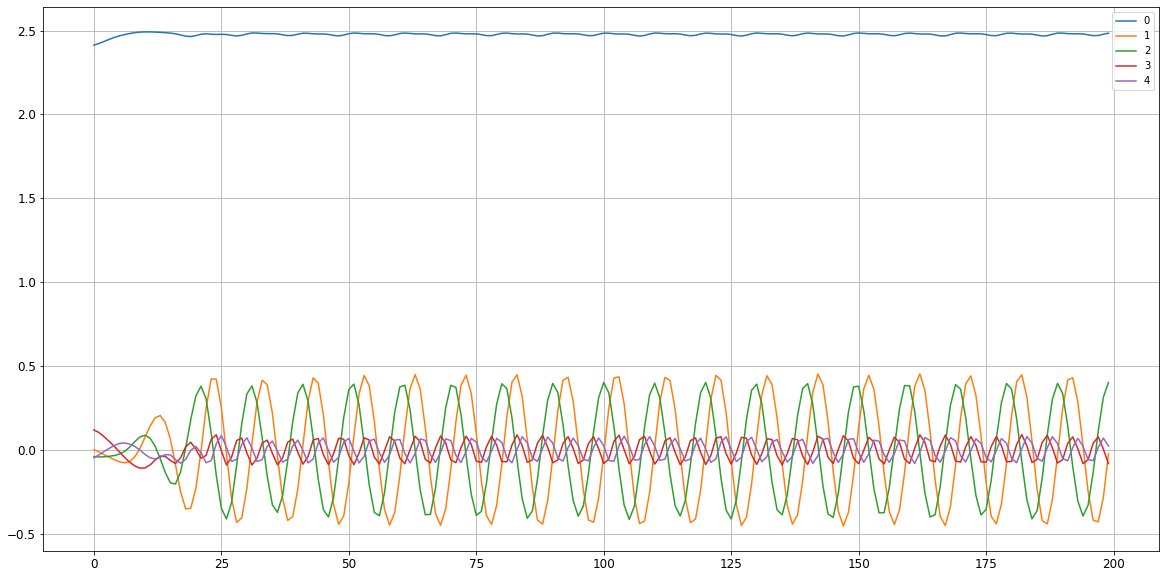

In [132]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times[:200], X_pod[:200]);
ax.grid()
ax.legend(range(5))

## Prepare data

In [154]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Reconstruct the time series into a supervised learning dataset.
    input:
    data, list or array, sequence of observations
    n_in, int, length of lagging observations (X)
    n_out, int, length of observations (y)
    dropnan, boolean, discard rows with NaN values
    return:
    Pandas DataFrame, reconstructed dataset
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input series (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # predict series (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concat column name with data
    agg = concat(cols, axis=1)
    agg.columns = names
    # discard rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [156]:
# create dataset
dataset = DataFrame()
for i in range(5):
    dataset['ob%d'%i] = X_pod[:,i]
values = dataset.values
# make sure all values are float
values = values.astype('float32')
# Normalized
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Structured as a supervised learning problem
reframed = series_to_supervised(scaled, 1, 1)

In [157]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.000000,0.501258,0.458296,1.000000,0.206070,0.129459,0.486425,0.455553,0.931075,0.312128
2,0.129459,0.486425,0.455553,0.931075,0.312128,0.278597,0.468906,0.457053,0.820970,0.432223
3,0.278597,0.468906,0.457053,0.820970,0.432223,0.438786,0.451980,0.460640,0.698643,0.544352
4,0.438786,0.451980,0.460640,0.698643,0.544352,0.584223,0.435882,0.466118,0.568340,0.648371
5,0.584223,0.435882,0.466118,0.568340,0.648371,0.702911,0.422165,0.476378,0.425185,0.719628


In [158]:
# split train and test set by 9:1
values = reframed.values
n_train = 898
train = values[:n_train, :]
test = values[n_train:, :]
# create input and output
X_train, y_train = train[:, :5], train[:, 5:]
X_test, y_test = test[:, :5], test[:, 5:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(898, 5) (898, 5) (100, 5) (100, 5)


## Train with MLP

In [26]:
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [165]:
epochs = 40
batch_size = 256
lr = 0.001
optimizer = optimizers.Adam(lr=lr, decay=0.0)

In [159]:
n_input = X_train.shape[1]
n_output = y_train.shape[1]

In [160]:
# design MLP
model = Sequential()
#model.add(Flatten(input_shape=X_train.shape))
model.add(Dense(100, activation="relu", input_dim=n_input))
model.add(Dense(n_output))
model.summary()
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 505       
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


In [162]:
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, shuffle=False)

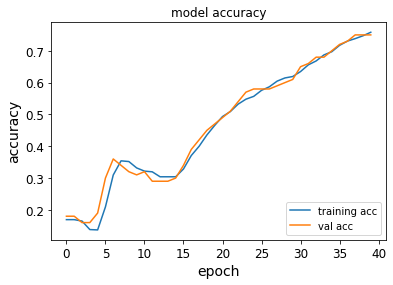

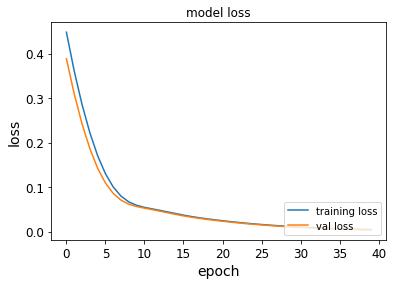

In [163]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['accuracy'],label='training acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

fig = plt.figure()
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')

Predict on test set

In [202]:
# make prediction
yhat = model.predict(X_test)
# Inverse scaling predicted value
yhat_inv = scaler.inverse_transform(yhat)
# Inverse scaling true value
y_inv = scaler.inverse_transform(y_test)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_inv, yhat_inv))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.035


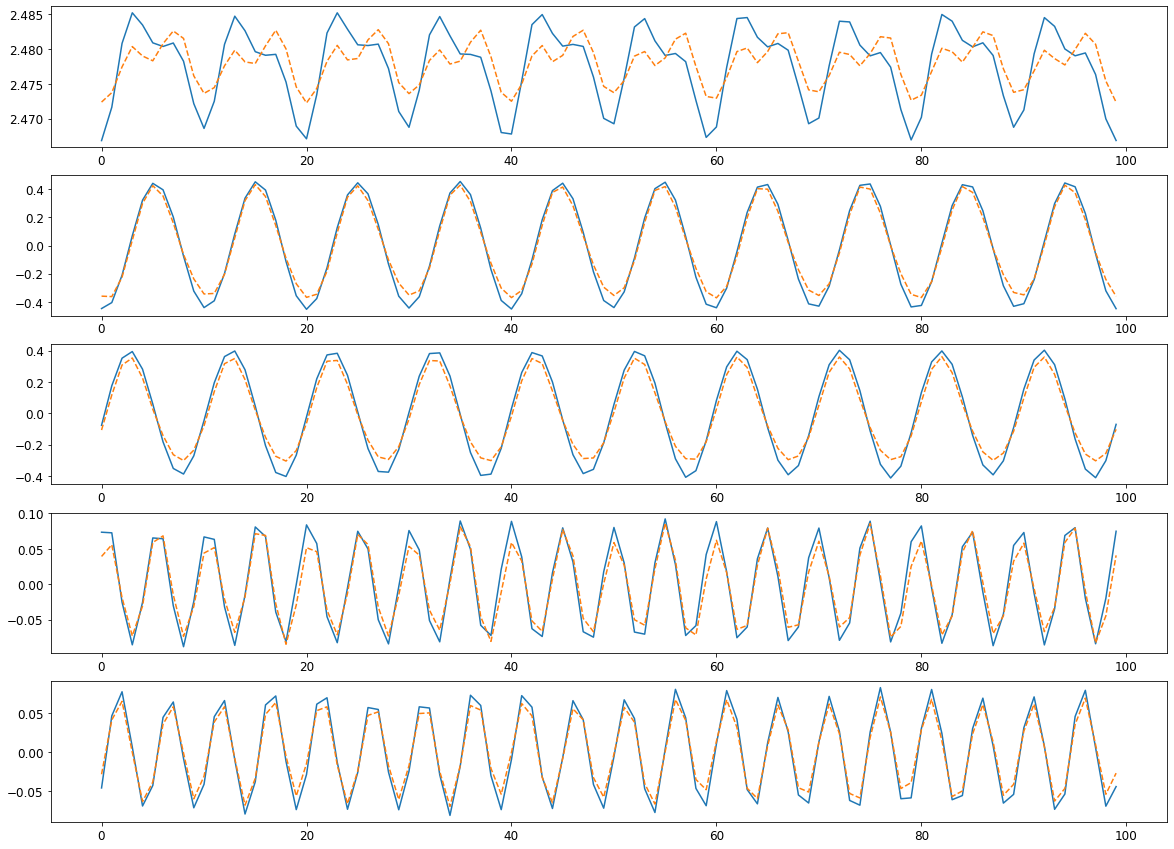

In [203]:
fig, ax = plt.subplots(5, 1, figsize=[20,15])
for i in range(5):
    ax.flatten()[i].plot(y_inv[:,i])
    ax.flatten()[i].plot(yhat_inv[:,i],'--')

Predict on full set

In [211]:
# make prediction
X_fullset = values[:, :5]
yhat = model.predict(X_fullset)
# Inverse scaling predicted value
yhat_inv = scaler.inverse_transform(yhat)
# Inverse scaling true value
y_inv = scaler.inverse_transform(values[:,-5:])
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_inv, yhat_inv))
print('Fullset RMSE: %.3f' % rmse)

Fullset RMSE: 0.036


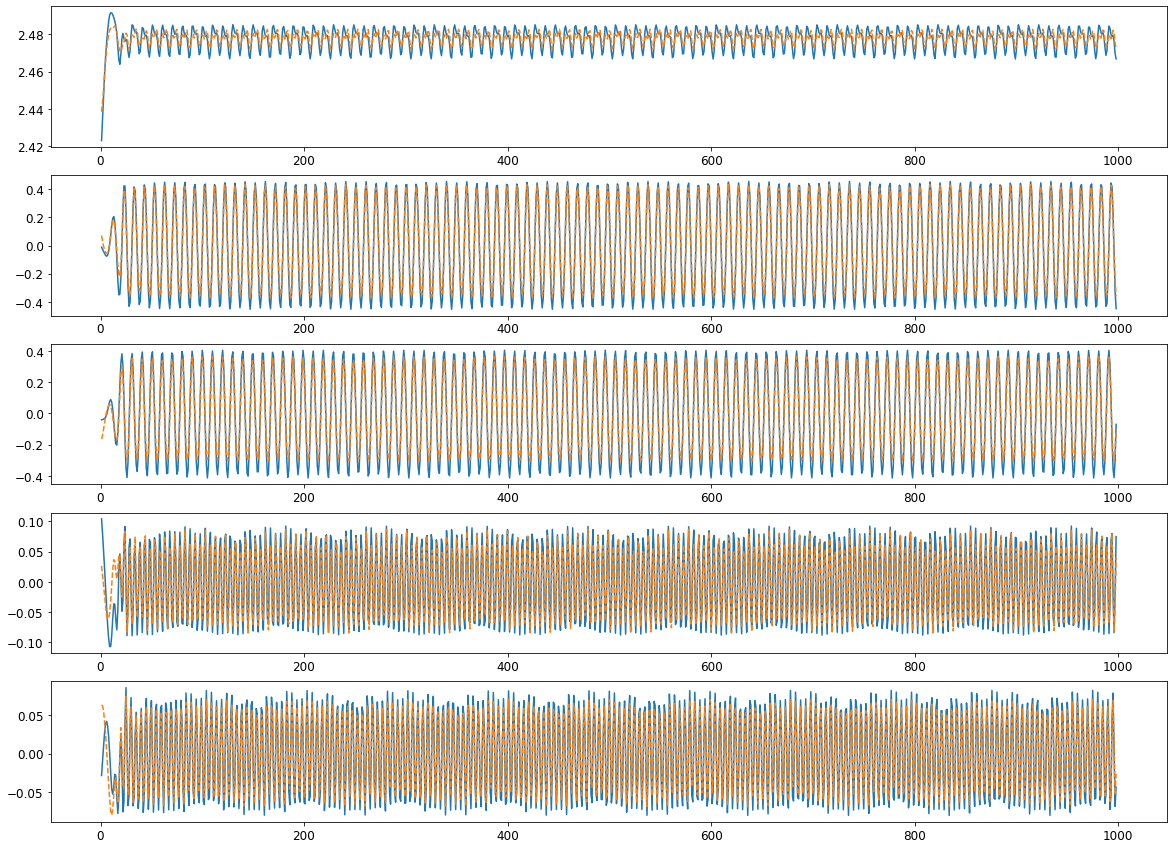

In [213]:
fig, ax = plt.subplots(5, 1, figsize=[20,15])
for i in range(5):
    ax.flatten()[i].plot(times[1:], y_inv[:,i])
    ax.flatten()[i].plot(times[1:], yhat_inv[:,i],'--')